In [1]:
import tensorflow as tf 
print(tf.__version__)


2.15.0


In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [3]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [4]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])


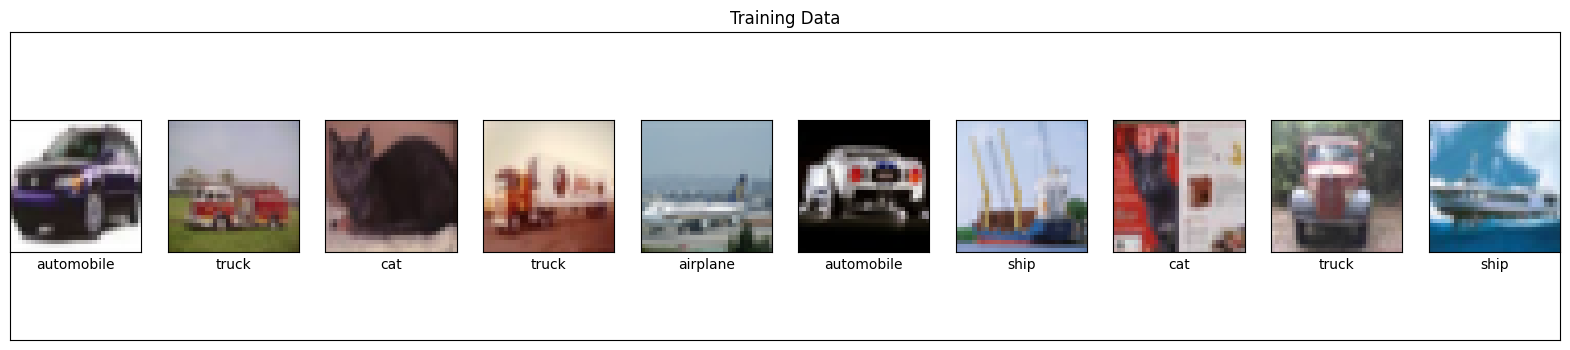

In [6]:
display_images(training_images, training_labels, training_labels, "Training Data" )

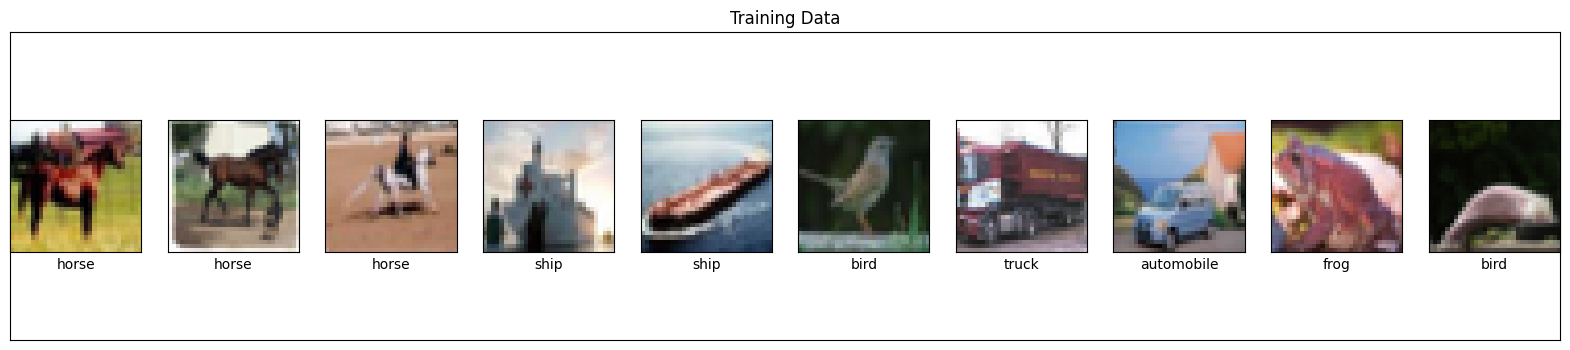

In [7]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

In [8]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  
  return output_ims

In [9]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [10]:
def feature_extractor(inputs):

  feature_extractor = base_model(inputs)
  for layer in base_model.layers:
    layer.trainable = False
  return feature_extractor


In [15]:
def classifier(inputs, dropout_rate=0.5):  # You can adjust the dropout rate
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(10, activation="sigmoid")(x)
    return x

In [16]:
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

In [17]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

In [18]:
model = define_compile_model()

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 224, 224, 3)       0         
 g2D)                                                            
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               2622

In [19]:
EPOCHS = 3
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/3


782/782 [==============================] - 2597s 3s/step - loss: 1.6704 - accuracy: 0.4014 - val_loss: 1.0109 - val_accuracy: 0.6761
Epoch 2/3
782/782 [==============================] - 2277s 3s/step - loss: 1.2289 - accuracy: 0.5723 - val_loss: 0.8622 - val_accuracy: 0.7182
Epoch 3/3
782/782 [==============================] - 1537s 2s/step - loss: 1.0807 - accuracy: 0.6319 - val_loss: 0.7640 - val_accuracy: 0.7476
